In [1]:
# Paquetes usados para la practica

from scipy import fftpack
from skimage.color import rgb2gray
from scipy.signal import convolve2d as convolve, correlate2d as correlate
import numpy as np
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from numpy import unravel_index
from scipy.signal import correlate2d


C:\Users\pedro\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Pedro Sendon Combalia
20329676

La presente práctica tiene como objetivo la reconstrucción de imágenes en color a partir de tomas separadas de los canales R, G y B de archivos en formato TIFF pertenecientes a la base de datos de la Library of Congress. Este proceso de reconstrucción consta de tres etapas fundamentales: la separación y alineación de los canales R, G y B, la implementación de la alineación mediante la descomposición piramidal de la imagen, y finalmente, la mejora de la apariencia de la imagen resultante mediante ajustes de brillo, balance de blanco, contraste, entre otros aspectos.

En la primera fase de la práctica, se aborda la separación de las imágenes y su posterior alineación. Se utiliza una imagen de referencia en formato TIFF, y mediante el uso de la biblioteca skimage, se extraen los canales R, G y B. Posteriormente, se implementa un método de alineación automática basado en la búsqueda y matching de regiones de imágenes, utilizando la técnica del cross-correlation. Este proceso se realiza primero entre los canales R y G, y luego entre los canales G y B.

En la segunda etapa, se introduce la alineación con descomposición piramidal. Este enfoque permite acelerar el proceso al calcular múltiples réplicas de la imagen original mediante filtrado de suavización y sub-muestreo. La búsqueda piramidal mejora la eficiencia al trabajar con áreas de búsqueda más pequeñas, lo que resulta en un tiempo de ejecución más rápido.

Se espera que al finalizar la práctica, se obtengan resultados visuales que muestren la alineación exitosa de los canales R, G y B, tanto a nivel general como en detalles específicos de la imagen final. Además, se espera que se implementen mejoras visuales mediante ajustes de brillo, balance de blanco y contraste, para lograr una imagen RGB final con una apariencia mejorada.

# 1. Separación y alineación de los canales R, G, B


## 1.1 Reconstruccion

Este código realiza varias operaciones en una imagen reducida para acelerar el procesamiento. Primero, se carga una imagen y se reduce su tamaño en un factor de 10. Luego, se define la posición de tres regiones de interés en la imagen reducida. Se extraen estos recortes y se normalizan para obtener los canales de color azul, rojo y verde respectivamente. Los canales se visualizan por separado y combinados en una imagen RGB.

The original image has size  (9588, 3732)
The resized image has a final size of  (959, 374)


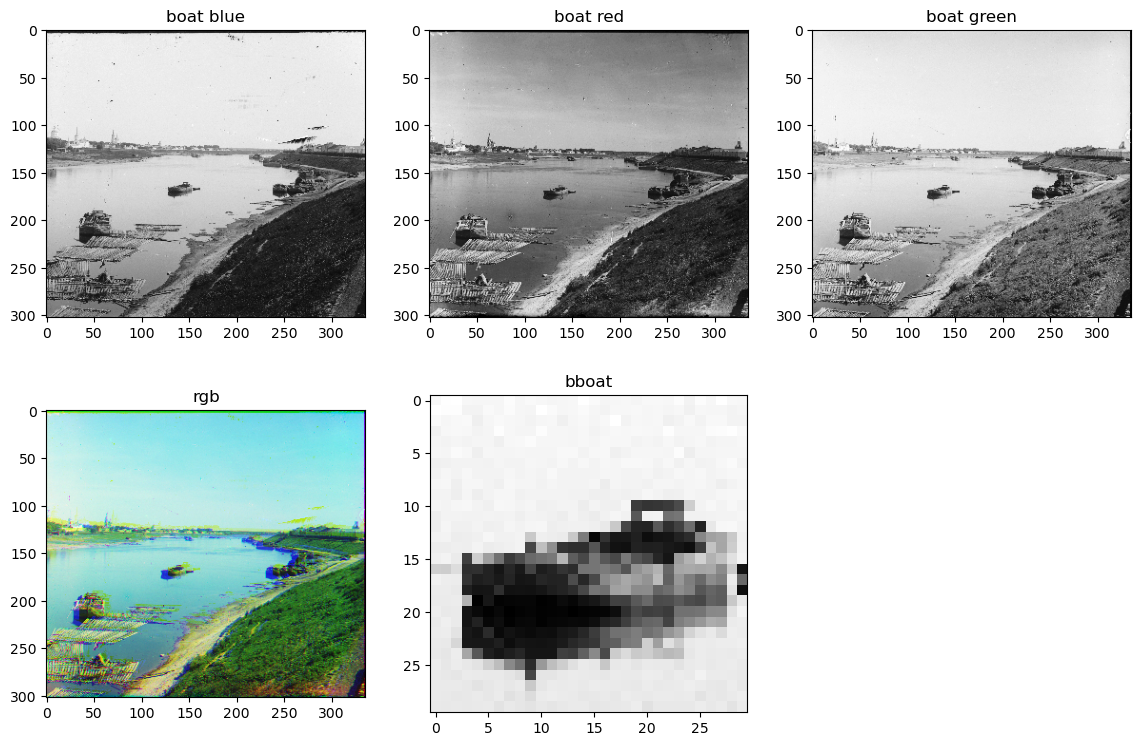

In [2]:
# RESIZE THE IMAGE FOR SPEED-UP
img = io.imread("images/00029u.png")
#RESIZE THE IMAGE FOR SPEED-UP
print('The original image has size ', img.shape)
img_np = img[::10,::10]
print('The resized image has a final size of ', img_np.shape)
#DEFINING THE POSITION OF THE TARGET OBJECT
x1 = 20; y1 = 20;
x2 = 25; y2 = 333;
x3 = 24; y3 = 647;
w = 336; h = 302;
im1 = img_np[y1-2:y1+h-2,x1-1:x1+w-1];
im2 = img_np[y2-2:y2+h-2,x2-1:x2+w-1];
im3 = img_np[y3-2:y3+h-2,x3-1:x3+w-1];
# Estos son los distintos canales de la imagen
B = 255*im1.astype('double')/im1.max();
G = 255*im2.astype('double')/im2.max();
R = 255*im3.astype('double')/im3.max();
""""""
# mostramos los distintos canales de la imagen
plt.subplot(331)
plt.title('boat blue')
imgplot1=plt.imshow(B,cmap="gray")
plt.subplot(332)
plt.title('boat red')
imgplot1=plt.imshow(R,cmap="gray")
plt.subplot(333)
plt.title('boat green')
imgplot1=plt.imshow(G,cmap="gray")
""""""
# mostramos los distintos canales, por separado y juntos
rgb = np.zeros((h, w, 3)).astype('int')
rgb[:,:,0],rgb[:,:,1],rgb[:,:,2]=R,G,B
plt.subplot(334)
plt.title('rgb')
imgplot1=plt.imshow(rgb,cmap="gray")
bpad=15;xbboat=140;ybboat=165
bboat=B[ybboat-bpad:ybboat+bpad,xbboat-bpad:xbboat+bpad]
plt.subplot(335)
plt.title('bboat')
imgplot1=plt.imshow(bboat,cmap="gray")

plt.gcf().set_size_inches((14,14))

## 1.2 Alineacion

Este código implementa la alineación de dos canales de una imagen en color (por ejemplo, canales R y G, o R y B) mediante correlación cruzada. La función cross_correlation encuentra el desplazamiento óptimo entre un bloque de la primera imagen (img) y una ventana de búsqueda en la segunda imagen (img2). Los resultados se visualizan mostrando los canales originales, los canales alineados y las imágenes de correlación cruzada. La función roll realiza el desplazamiento necesario para la alineación. La normalización se realiza para mejorar la robustez del proceso.

Vector de desplazamiento R y G: (0, 0)
Vector de desplazamiento R y B: (7, -3)


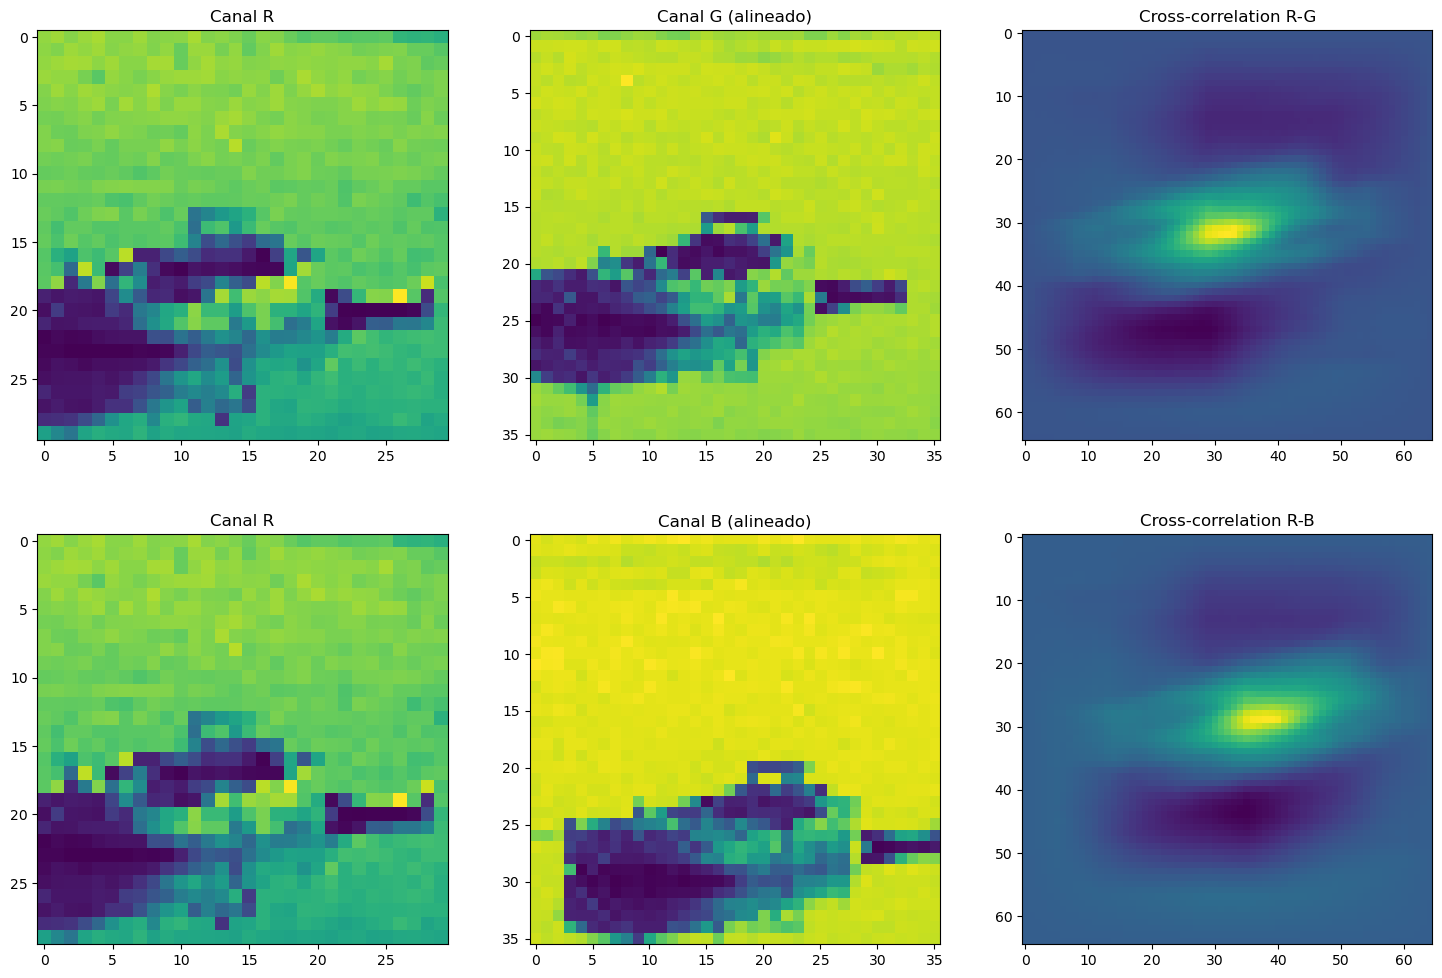

In [3]:
def cross_correlation(img,img2,xb=140,yb=165,psize=15,size_search=3):
    #Definir el template
    template= normalize(img[yb-psize:yb+psize,xb - psize: xb + psize])

    #Definimos la ventana
    search_window = normalize(img2[yb-psize-size_search:yb+psize+size_search,xb - psize-size_search: xb + psize + size_search])

    #Correlacion entre bloque y ventana
    NCC= correlate2d(search_window.astype("float"),template.astype("float"),mode="full",boundary='fill', fillvalue=0.)

    #Punto correlacion
    index= np.unravel_index(np.argmax(NCC),NCC.shape)
    vector= (index[1] - int(NCC.shape[1]/2),index[0] - int(NCC.shape[0]/2))

    img2_alligned= np.roll(img2,(vector[1],vector[0]),axis=(1,0))

    #Alineamos la segunda imagen
    align= img2_alligned[yb-psize-size_search:yb+psize+size_search,xb - psize-size_search: xb + psize + size_search]

    return template, align, vector, NCC
def roll(img, dispX, dispY):
    # Shift along the x-axis (columns)
    copyX = img[:, 0:-dispX]
    img = np.concatenate((img[:, -dispX:img.shape[1]], copyX), axis=1)

    # Shift along the y-axis (rows)
    copyY = img[0:-dispY, :]
    img_shifted = np.concatenate((img[-dispY:img.shape[0], :], copyY), axis=0)

    return img_shifted
def normalize(img):
    img_min = np.min(img)
    img_max = np.max(img)
    img_mean = np.mean(img)

    normalized_img = (img - img_min) / (img_max - img_min)
    normalized_img -= np.mean(normalized_img)

    return normalized_img


# Alinear R y G
template_RG, align_RG, vector_RG, NCC_RG = cross_correlation(R, G)

# Alinear R y B
template_RB, align_RB, vector_RB, NCC_RB = cross_correlation(R, B)

print("Vector de desplazamiento R y G:", vector_RG)
print("Vector de desplazamiento R y B:", vector_RB)

# Visualizar los resultados
plt.subplot(231)
plt.title('Canal R')
plt.imshow(template_RG)

plt.subplot(232)
plt.title('Canal G (alineado)')
plt.imshow(align_RG)

plt.subplot(233)
plt.title('Cross-correlation R-G')
plt.imshow(NCC_RG)

plt.subplot(234)
plt.title('Canal R')
plt.imshow(template_RB)

plt.subplot(235)
plt.title('Canal B (alineado)')
plt.imshow(align_RB)

plt.subplot(236)
plt.title('Cross-correlation R-B')
plt.imshow(NCC_RB)

plt.gcf().set_size_inches((18, 12))
plt.show()


Red-Blue Movement Vector: 1 -17
Green-Blue Movement Vector: 0 -17


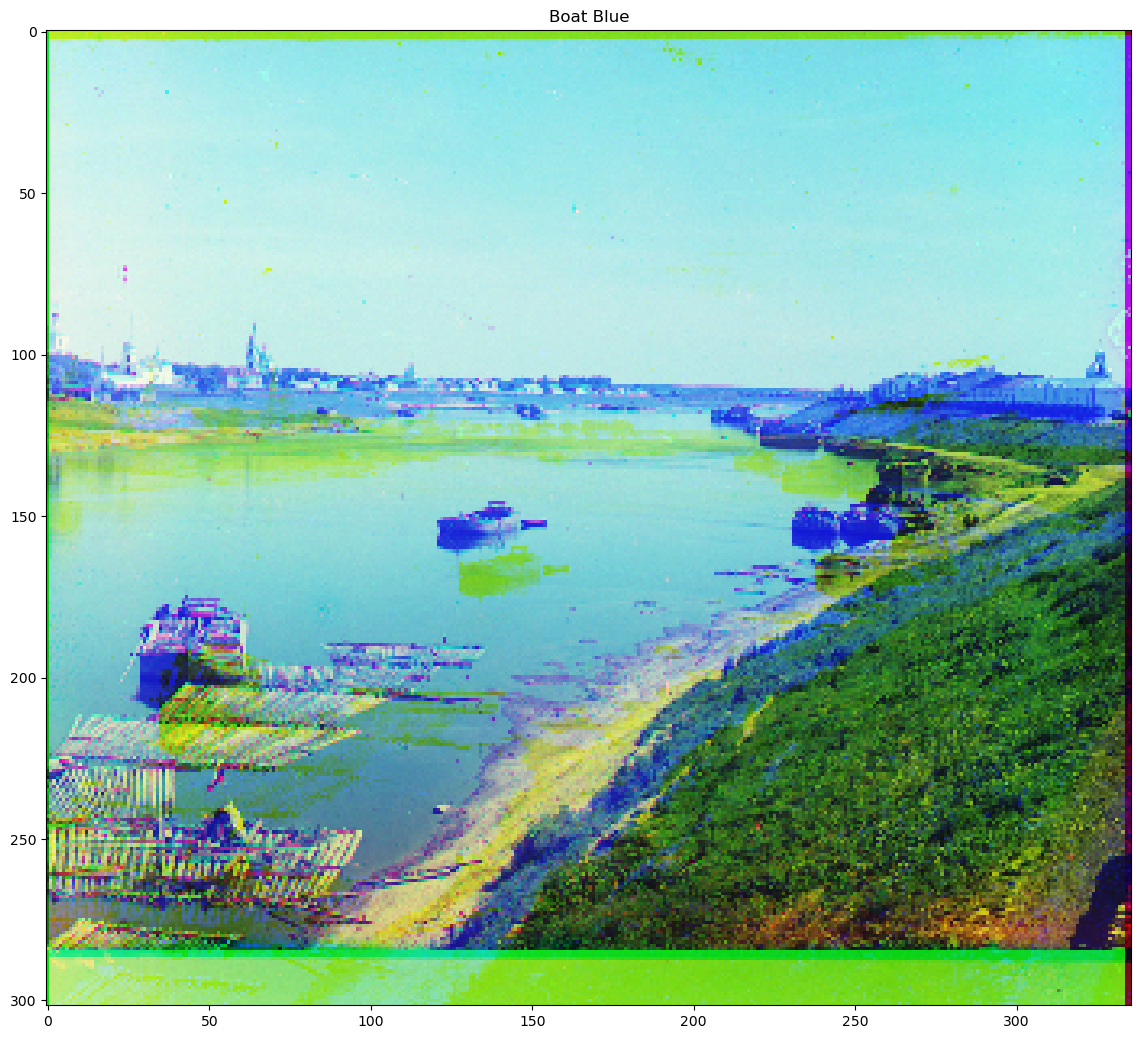

In [4]:
# Function to shift an image
bb = B
rb = R
gb = G


# Function to find the movement vector
def find_movement_vector(normalized_cross_correlation):
    source = normalized_cross_correlation.shape[0] // 2
    y, x = np.unravel_index(np.argmax(normalized_cross_correlation), normalized_cross_correlation.shape)
    return -y + source, -x + source

# Function to align a channel with another
def align_channel(reference, other):
    cross_correlation = correlate(reference, other, mode='same', boundary='fill', fillvalue=0.)
    movement_vector = find_movement_vector(cross_correlation)
    print("Movement Vector:", movement_vector)
    return roll(other, movement_vector[0], axis=0), roll(other, movement_vector[1], axis=1)

# Example usage:
# Get the movement vector for aligning the red channel with the blue channel
cross_correlation_result_red_blue = correlate(bb, rb, mode='same', boundary='fill', fillvalue=0.)
movement_vector_red_blue_X, movement_vector_red_blue_Y = find_movement_vector(cross_correlation_result_red_blue)

# Get the movement vector for aligning the green channel with the blue channel
cross_correlation_result_green_blue = correlate(bb, gb, mode='same', boundary='fill', fillvalue=0.)
movement_vector_green_blue_X, movement_vector_green_blue_Y = find_movement_vector(cross_correlation_result_green_blue)

# Combine the results into a new RGB image
height, width = R.shape
print("Red-Blue Movement Vector:", movement_vector_red_blue_X, movement_vector_red_blue_Y)
print("Green-Blue Movement Vector:", movement_vector_green_blue_X, movement_vector_green_blue_Y)

# Create an RGB image before and after alignment
rgb_before_alignment = np.zeros((height, width, 3)).astype('int')
rgb_before_alignment[:, :, 0], rgb_before_alignment[:, :, 1], rgb_before_alignment[:, :, 2] = R, G, B

rgb_after_alignment = np.zeros((height, width, 3)).astype('int')
rgb_after_alignment[:, :, 0], rgb_after_alignment[:, :, 1], rgb_after_alignment[:, :, 2] = roll(R, movement_vector_red_blue_X, movement_vector_red_blue_Y), \
                                                                                         roll(G, movement_vector_green_blue_X, movement_vector_green_blue_Y), B

# Display the aligned image
plt.subplot(111)
plt.title('Boat Blue')
imgplot = plt.imshow(rgb_after_alignment)
plt.gcf().set_size_inches((14, 14))
plt.show()

# 2. Alineación con descomposición piramidal

Este código implementa una alineación piramidal entre dos imágenes en diferentes escalas. La función pyramid_alignment itera sobre las escalas, redimensiona las imágenes, realiza la alineación utilizando correlación cruzada, y muestra visualizaciones de los canales originales y alineados, junto con la correlación cruzada. Se realiza la alineación de los canales R y G, y luego de los canales G y B, utilizando dos llamadas a esta función con parámetros específicos.

Displacement vector at scale 1: (0, 0)


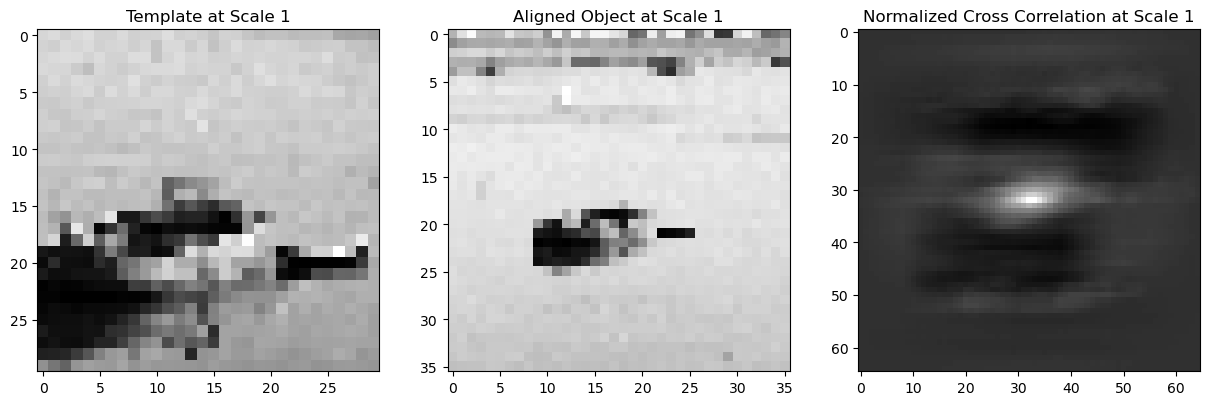

Displacement vector at scale 0: (0, 0)


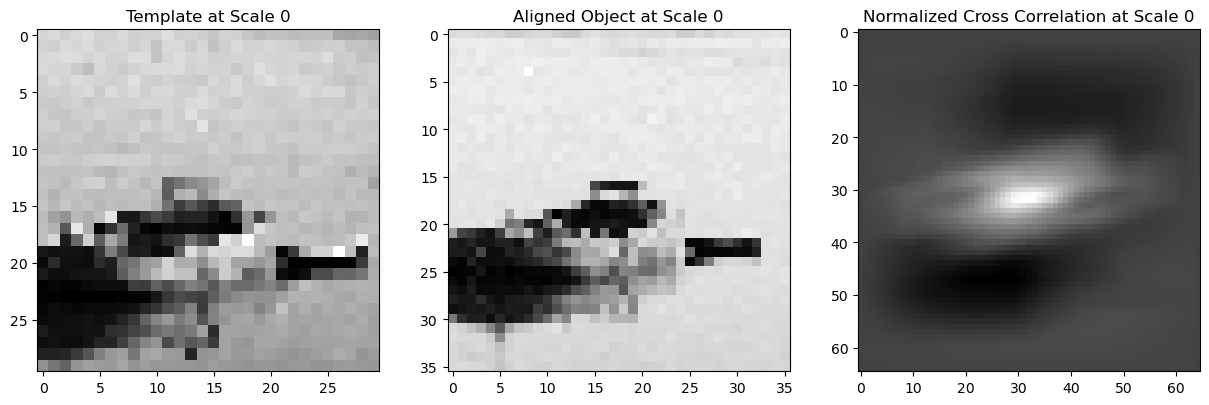

In [5]:
def pyramid_alignment(img1, img2, xb, yb, psize, size_search, scales):
    for scale in scales:
        # Resize images to the current scale
        img1_resized = img1[::2**scale, ::2**scale]
        img2_resized = img2[::2**scale, ::2**scale]

        # Define the template (block) in the resized image
        template = normalize(img1[yb-psize:yb+psize, xb - psize: xb + psize])

        # Perform cross-correlation at the current scale
        _, aligned, vector, NCC = cross_correlation(img1_resized, img2_resized, xb // (2**scale), yb // (2**scale), psize, size_search)

        if aligned is None:
            print(f"No valid correlation found at scale {scale}")
            continue

        # Upsample the vector to the original scale
        vector_upsampled = (vector[0] * 2**scale, vector[1] * 2**scale)

        # Apply the displacement to the original image
        img2_aligned = roll(img2, vector_upsampled[0], vector_upsampled[1])

        # Print displacement vector
        print(f"Displacement vector at scale {scale}:", vector_upsampled)

        # Visualize the results
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.title(f'Template at Scale {scale}')
        plt.imshow(template, cmap='gray')

        plt.subplot(132)
        plt.title(f'Aligned Object at Scale {scale}')
        plt.imshow(aligned, cmap='gray')

        plt.subplot(133)
        plt.title(f'Normalized Cross Correlation at Scale {scale}')
        plt.imshow(NCC, cmap='gray')

        plt.show()

# Set parameters
xb = 140
yb = 165
psize = 15
size_search = 3
scales = [1, 0]  # Scales for pyramid decomposition

# Perform pyramid decomposition and alignment for R with G
pyramid_alignment(R, G, xb, yb, psize, size_search, scales)
